In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from opera_tropo.product_info import TROPO_PRODUCTS
from opera_tropo.core import calculate_ztd

In [3]:
work_dir = Path('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/')

In [4]:
import xarray as xr
ds = xr.open_dataset(work_dir / 'D06130000061300001.zz.nc',
                     chunks={})

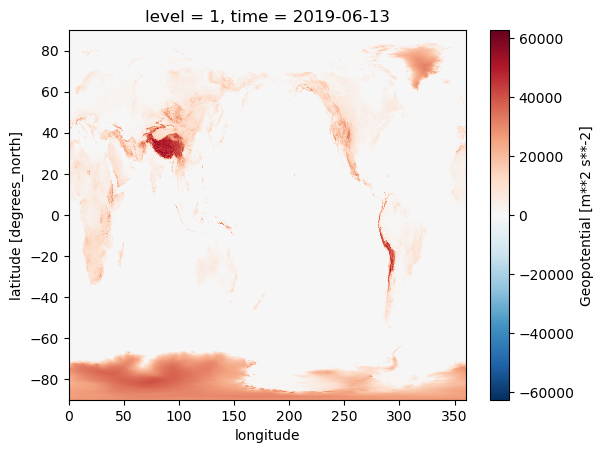

In [11]:
ds.isel(time=0, level=0).z.plot.imshow()

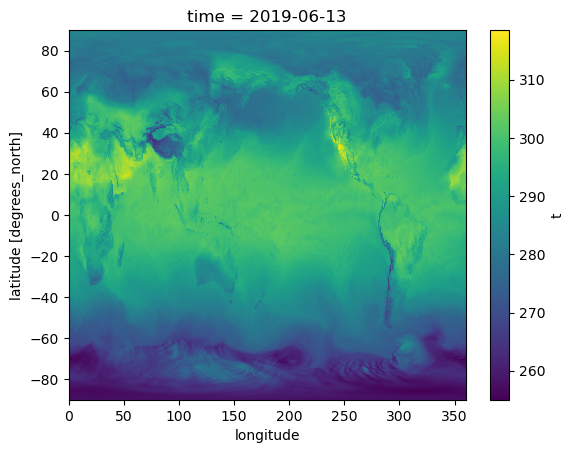

In [12]:
ds.isel(time=0).t.max(dim='level').plot.imshow()

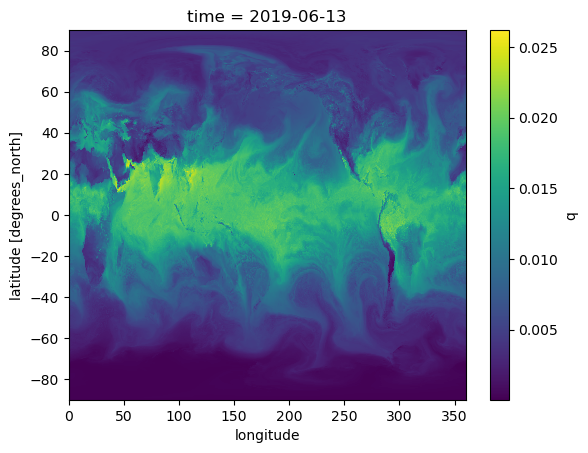

In [13]:
ds.isel(time=0).q.max(dim='level').plot.imshow()

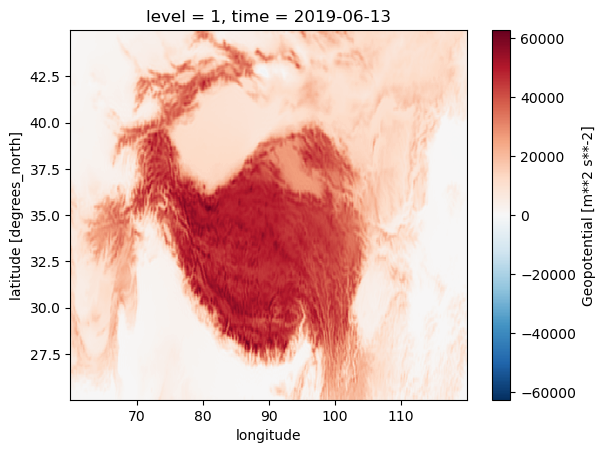

In [14]:
ds.isel(level=0, time=0).sel(latitude=slice(45, 25), longitude=slice(60, 120)).z.plot.imshow()

In [17]:
subset_ds = ds.sel(latitude=slice(40, 25), longitude=slice(60, 110))
subset_ds

<xarray.Dataset> Size: 332MB
Dimensions:    (time: 1, level: 137, latitude: 213, longitude: 711)
Coordinates:
  * longitude  (longitude) float32 3kB 60.05 60.12 60.19 ... 109.8 109.9 110.0
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2019-06-13
Data variables:
    z          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    lnsp       (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-12-11 19:08:29 GMT by grib_to_netcdf-2.28.1: grib_to_n...

# Compare rounding results

In [22]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 6
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 6
out_ds_6 = calculate_ztd(subset_ds)

CPU times: user 30.1 s, sys: 24.8 s, total: 54.8 s
Wall time: 53.8 s


In [23]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 8
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 8
out_ds_8 = calculate_ztd(subset_ds)

CPU times: user 30.1 s, sys: 24.1 s, total: 54.2 s
Wall time: 53.2 s


In [24]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 10
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 10
out_ds_10 = calculate_ztd(subset_ds)

CPU times: user 31.4 s, sys: 23.7 s, total: 55.1 s
Wall time: 54.1 s


In [25]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 12
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 12
out_ds_12 = calculate_ztd(subset_ds)

CPU times: user 30 s, sys: 23.4 s, total: 53.4 s
Wall time: 52.3 s


In [26]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 14
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 14
out_ds_14 = calculate_ztd(subset_ds)

CPU times: user 30.3 s, sys: 23.8 s, total: 54.1 s
Wall time: 53.1 s


In [34]:
%%time
#  Without rounding
out_ds = calculate_ztd(subset_ds, keep_bits=False)

CPU times: user 30.3 s, sys: 22.7 s, total: 53 s
Wall time: 51.8 s


In [35]:
# Get different round results
ds_dict = {'6': out_ds_6,
          '8': out_ds_8,
          '10': out_ds_10,
          '12': out_ds_12,
          '14': out_ds_14,
          'no': out_ds}

In [99]:
import pandas as pd
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from collections import namedtuple
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Define base namedtuple
_round_stat = namedtuple('test', ['min', 'mean', 'max', 'amax'])

def get_rounding_precision(ds1, ds2, layer):
    # Create a new namedtuple class with a dynamic typename
    RoundStat = namedtuple(layer, _round_stat._fields)

    # Compute values and instantiate the namedtuple
    round_stat_instance = RoundStat(
        min=(ds1[layer] - ds2[layer]).min().values.item(),
        mean=(ds1[layer] - ds2[layer]).mean().values.item(),
        max=(ds1[layer] - ds2[layer]).max().values.item(),
        amax=(np.abs(ds1[layer] - ds2[layer])).max().values.item()
    )

    return round_stat_instance


# Crosstab

def get_cross_tab(ds_dict,
                  labels=['6', '8', '10', '12', '14', 'no'],
                  layer='wet_delay',
                  metric='amax'):
    in_dict = dict((key, None) for key in labels)
    out_dict = dict((key, in_dict.copy()) for key in labels) 

    for key1 in labels:
        for key2 in labels:
            if metric == 'min':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).min 
            elif metric == 'max':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).max
            elif metric == 'mean':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).mean
            elif metric == 'amax':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).amax
    return pd.DataFrame(out_dict)


def _plot_crosstab(fig, ax, df, layer='wet_delay'):
    # Plot heatmap using imshow()
    df *= 1e3
    #norm = TwoSlopeNorm(vmin=df.min().min()-1e-10, vcenter=0, vmax=df.max().max()+1e-10)
    cax = ax.imshow(df.values, cmap="copper_r", aspect="auto", alpha=0.6)

    # Add colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label("mm")

    # Add numbers inside each cell
    for i in range(df.shape[0]):  # Iterate over rows
        for j in range(df.shape[1]):  # Iterate over columns
            text = f"{df.iloc[i, j]:.3f}"  # Format number to 5 decimal places

            # Set font to bold for last row or column
            font = 'bold' if (i == df.shape[0] - 1) or (j == df.shape[1] - 1) else 'normal'
            #color = 'red' if (i == df.shape[0] - 1) or (j == df.shape[1] - 1) else 'black'

            # Add the text inside each cell
            ax.text(j, i, text, ha="center", va="center", color='black', weight=font, fontsize=10)



    # Add gridlines
    ax.set_xticks(np.arange(df.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(df.shape[0] + 1) - 0.5, minor=True)
    ax.set_xticklabels(np.append('0',df.columns))
    ax.set_yticklabels(np.append('0', df.index))
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.set_xlabel('bits')
    ax.set_ylabel('bits')
    # Hide the minor ticks to only show the grid
    ax.tick_params(which="minor", size=0)

    # Rotate x-axis labels for better readability
    ax.set_title(f'{layer} rounding diff.')

    return ax

Text(0.5, 0.98, 'Mantissa rounding difference')

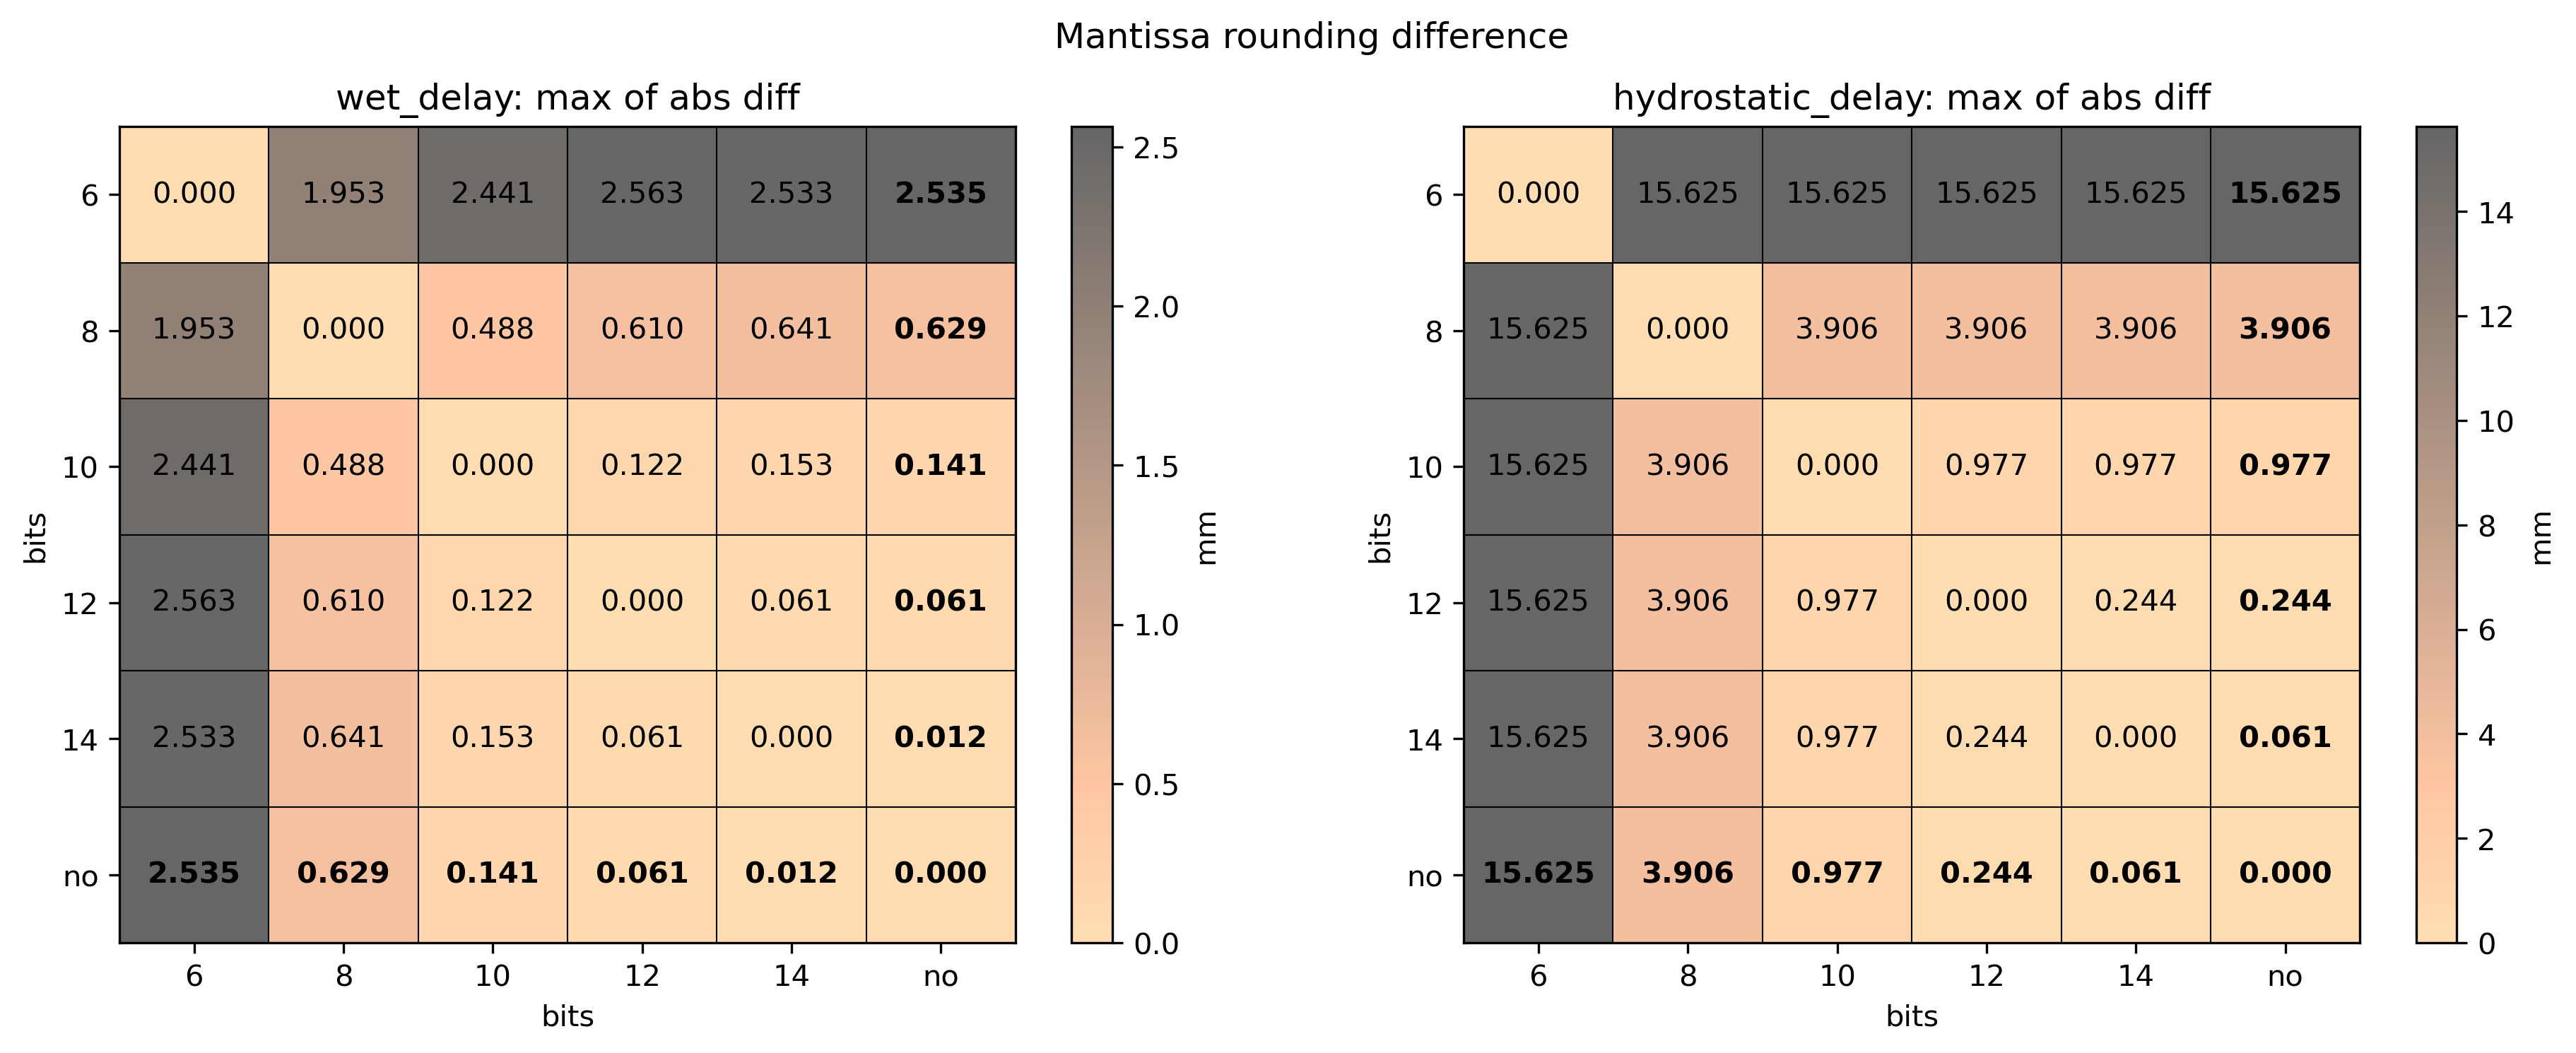

In [100]:
df_min = get_cross_tab(ds_dict, metric='amax', layer='wet_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='hydrostatic_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('wet_delay: max of abs diff')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('hydrostatic_delay: max of abs diff')
fig.suptitle('Mantissa rounding difference')